# Tests a network

In [ ]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append("../common/")

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [ ]:
from data_utils import TRAIN_IMAGE_IDS, LABELS
from image_utils import get_image_data, TRAIN_DATA, TRAIN_LABEL_TILES, get_image_tile_data, normalize
from visu_utils import display_img_1b, display_labels

In [ ]:
import cv2

### Input data

Images of shape (512, 512, 17) 

In [5]:
from unet import unet_zero

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release.  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '8784' (I am process '1724')
Using gpu device 0: GeForce GTX 750 Ti (CNMeM is enabled with initial size: 85.0% of memory, cuDNN 4007)


In [6]:
for i, l in enumerate(LABELS[1:]):
    print i, l

0 Buildings
1 Misc. Manmade structures
2 Road
3 Track
4 Trees
5 Crops
6 Waterway
7 Standing water
8 Vehicle Large
9 Vehicle Small


In [7]:
# RESIZE_TILES = False
# # tile_size = (512, 512)
# tile_size = (128, 128)
# n_channels = 17
# model = unet_zero(len(LABELS)-1, n_channels, *tile_size)

In [8]:
RESIZE_TILES = True
tile_size = (128, 128)
channels = np.array(range(11))
n_channels = len(channels)
labels = np.array(range(len(LABELS)))
n_labels = len(labels)

model = unet_zero(n_labels, n_channels, *tile_size)

In [9]:
channels, labels

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 11, 128, 128)  0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 128, 128)  3200        input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 128, 128)  9248        convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 64, 64)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [11]:
import os
from keras.optimizers import Adam, Nadam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from metrics import jaccard_coef, jaccard_coef_int

In [14]:
from glob import glob
all_train_tiles = glob(os.path.join(TRAIN_DATA, "*.tif"))
all_train_tiles = np.array([s[len(TRAIN_DATA)+1:] for s in all_train_tiles])

In [15]:
all_train_tiles[0]

'6010_1_2_0_0.tif'

In [16]:
from sklearn.model_selection import train_test_split 

# TRAIN ON N TILES
n_tiles = 256
if n_tiles > 0:
    train_tiles, val_tiles = train_test_split(all_train_tiles[:n_tiles], test_size=0.3)
else:
    train_tiles, val_tiles = train_test_split(all_train_tiles, test_size=0.3)
    
print len(train_tiles), len(val_tiles)

179 77


In [17]:
def normalize_image(img_data, max_value=1.0):
    if RESIZE_TILES:
        out = cv2.resize(img_data, dsize=tile_size, interpolation=cv2.INTER_CUBIC).astype(np.float32)
        if len(out.shape) == 2:
            out = out[:, :, None]
    else:
        out = img_data.astype(np.float32)

#     if max_value > 1.0:
#         out *= 1.0/max_value    
    if max_value > 1.0:  
        out = normalize(out, 0.01, 99.9)        
    
    out = out.transpose([2,0,1])
    return out


def generate_images(train_tiles, batch_size):
    while True:
        n = len(train_tiles)
        n_batches = n // batch_size
        random_indices = np.arange(n)
        np.random.shuffle(random_indices)
        for i in range(n_batches):
            end = min((i+1)*batch_size, n) 
            batch_indices = random_indices[batch_size*i:end]
            X = np.zeros((batch_size, n_channels)+tile_size, dtype=np.float32)
            Y = np.zeros((batch_size, n_labels)+tile_size, dtype=np.float32)
            for j, tile_id in enumerate(train_tiles[batch_indices]):
                x = get_image_tile_data(os.path.join(TRAIN_DATA,tile_id))
                y = get_image_tile_data(os.path.join(TRAIN_LABEL_TILES,tile_id))

                if n_labels < len(LABELS) - 1:
                    y = y[:,:,labels]
                if n_channels < 17:
                    x = x[:,:,channels]

                x = normalize_image(x, 2.0**10)
                y = normalize_image(y)     
                
                X[j,:,:,:] = x
                Y[j,:,:,:] = y 
                
            yield (X, Y)

(5L, 11L, 128L, 128L) (5L, 11L, 128L, 128L)
0.0 1.0 0.0 1.0


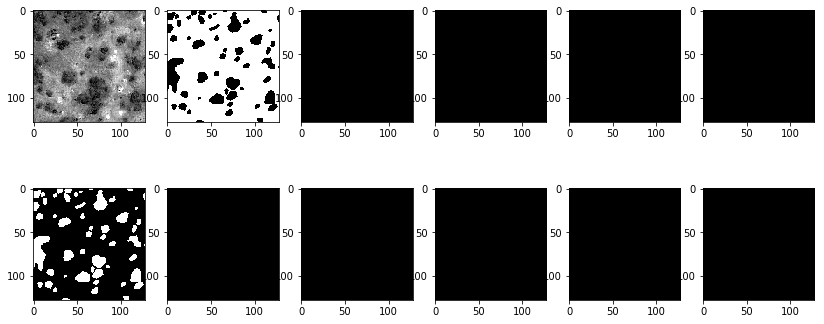

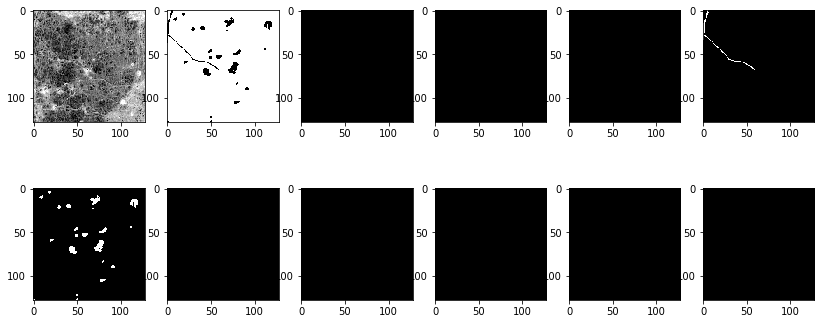

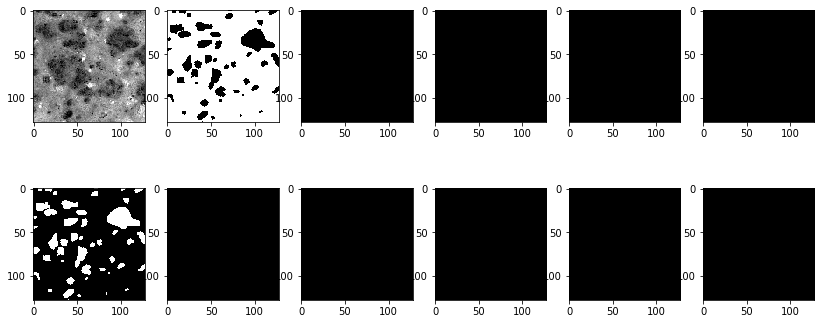

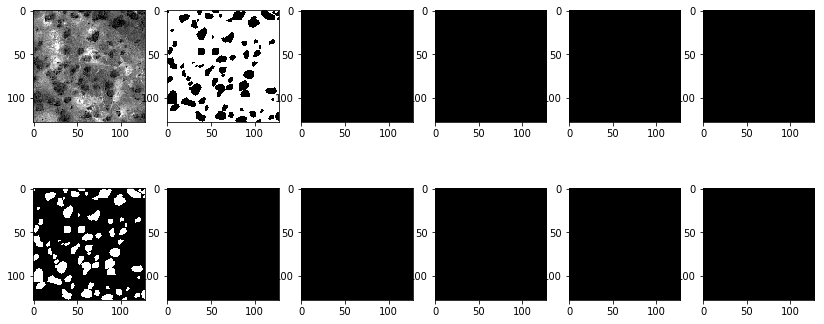

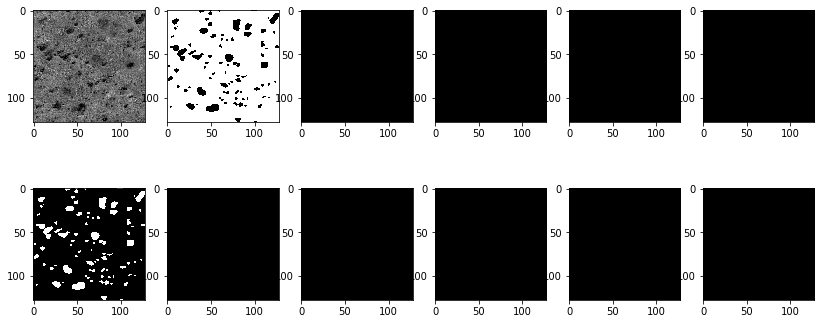

In [18]:
batch_size = 5
for X, Y in generate_images(train_tiles, batch_size):
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()
    
    for i in range(batch_size):
        plt.figure(figsize=(14, 6))    
        plt.subplot(261)
        display_img_1b(X[i,1,:,:])
        for j in range(n_labels):
            plt.subplot(2,6,j+2)
            display_img_1b(Y[i,j,:,:])

    break

In [20]:
if not os.path.exists('weights'):
    os.mkdir('weights')
    
model_checkpoint = ModelCheckpoint('weights/unet_zero.h5', monitor='loss', save_best_only=True)
earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0)

# LearningRateScheduler

In [21]:
# model.compile(optimizer=Nadam(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
model.compile(optimizer=Nadam(lr=0.001), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

# model.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
# model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

# sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

We have 25 images splitted into 64 tiles. It gives 1600 tiles to train on.
Train/test split with test size 0.3 gives: 1120 and 480 number of tiles.
Assembling 32 tiles in a batch, we obtain 35 batches for training tiles and 15 batches for validation.

In [23]:
from keras.callbacks import RemoteMonitor
rmon = RemoteMonitor(root='http://localhost:9000', path='/publish/epoch/end/', field='data', headers={'Content-Type': 'application/json', 'Accept': 'application/json'})

In [ ]:
foo = lambda x: max(x // 10, min(batch_size * 10, x))

batch_size = 8
samples_per_epoch = foo(len(train_tiles))
nb_val_samples = foo(len(val_tiles))


print batch_size, samples_per_epoch, nb_val_samples

history = model.fit_generator(
    generate_images(train_tiles, batch_size),
    samples_per_epoch=samples_per_epoch, 
    nb_epoch=150,
    validation_data=generate_images(val_tiles, batch_size),
    nb_val_samples=nb_val_samples,
    callbacks=[model_checkpoint, rmon],
    verbose=2
)

8 80 77


INFO (theano.gof.compilelock): Refreshing lock C:\Users\victor.fomin\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-2.7.11-64\lock_dir\lock
INFO (theano.gof.compilelock): Refreshing lock C:\Users\victor.fomin\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-2.7.11-64\lock_dir\lock
INFO (theano.gof.compilelock): Refreshing lock C:\Users\victor.fomin\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-2.7.11-64\lock_dir\lock


Epoch 1/150


f:\vfomin\myexamples\dl\venv\lib\site-packages\keras\callbacks.py:511: UserWarning: Warning: could not reach RemoteMonitor root server at http://localhost:9000
  'root server at ' + str(self.root))


39s - loss: 77.1448 - jaccard_coef: 1.6805e-06 - jaccard_coef_int: 1.3519e-12 - acc: 0.1604 - val_loss: 69.8316 - val_jaccard_coef: 1.7002e-06 - val_jaccard_coef_int: 1.1214e-12 - val_acc: 0.0814
Epoch 2/150
28s - loss: 65.6068 - jaccard_coef: 1.5728e-06 - jaccard_coef_int: 1.8499e-12 - acc: 0.0710 - val_loss: 61.6539 - val_jaccard_coef: 2.4768e-06 - val_jaccard_coef_int: 2.6369e-12 - val_acc: 0.0192
Epoch 3/150
29s - loss: 59.9132 - jaccard_coef: 2.6928e-06 - jaccard_coef_int: 2.3149e-12 - acc: 0.0233 - val_loss: 58.2629 - val_jaccard_coef: 5.0129e-06 - val_jaccard_coef_int: 3.0372e-12 - val_acc: 0.0403
Epoch 4/150
27s - loss: 57.4559 - jaccard_coef: 3.5906e-06 - jaccard_coef_int: 2.5895e-12 - acc: 0.0312 - val_loss: 56.8143 - val_jaccard_coef: 3.7028e-06 - val_jaccard_coef_int: 2.1643e-12 - val_acc: 0.0184
Epoch 5/150
23s - loss: 56.6831 - jaccard_coef: 4.7335e-06 - jaccard_coef_int: 2.1399e-12 - acc: 0.0223 - val_loss: 56.3674 - val_jaccard_coef: 4.9951e-06 - val_jaccard_coef_int: 2

In [33]:
plt.plot(history.history['val_jaccard_coef_int'])
plt.ylabel('Jaccard coeff integer')
# plt.plot(history.history['val_jaccard_coef'])
# plt.ylabel('Jaccard coeff')
plt.xlabel('Training iterations')
plt.legend(['Testing'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [20]:
def _plot(X, Y, Y_pred, i, c=1):
    plt.figure(figsize=(12,6))
    plt.subplot(131)
    display_img_1b(X[i,0,:,:])
    plt.subplot(132)
    display_img_1b(Y[i,c,:,:])
    plt.subplot(133)
    display_img_1b(Y_pred[i,c,:,:])

(5, 11, 128, 128) 7.56982e-22 0.000444466


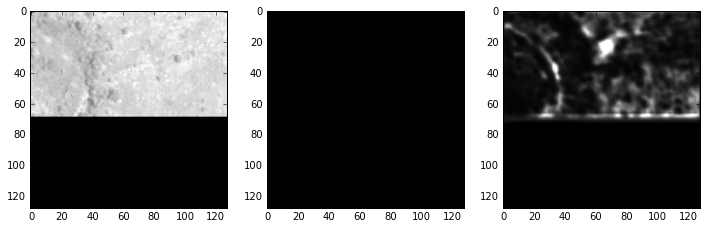

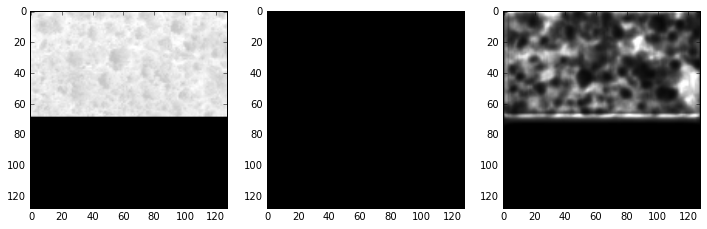

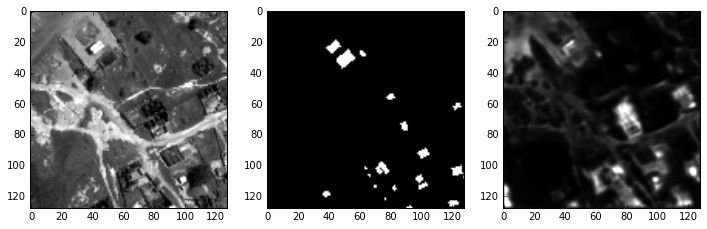

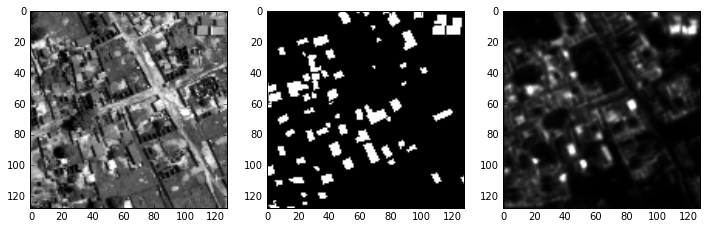

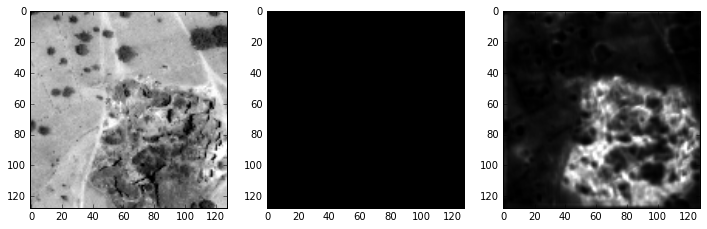

In [21]:
batch_size = 5

for X, Y in generate_images(train_tiles, batch_size):
    Y_pred = model.predict_on_batch(X)
    print Y_pred.shape, Y_pred.min(), Y_pred.max()

    for i in range(batch_size):
        _plot(X, Y, Y_pred, i)

#     print jaccard_coef(Y, Y_pred), jaccard_coef_int(Y, Y_pred)
    break


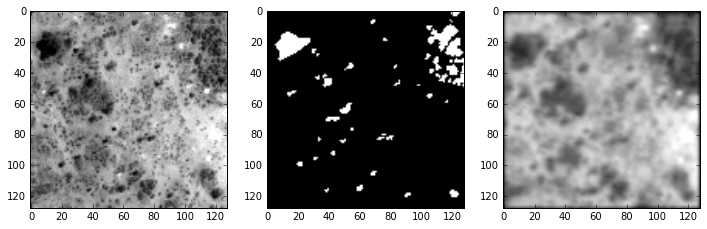

In [42]:
_plot(X, Y, Y_pred, 0, 0)

In [22]:
y = Y_pred[0,1,:,:]
print y.min(), y.max()

2.11063e-12 0.000444466
